In [597]:
import os
import re
from tqdm import tqdm
import pandas as pd
import numpy as np
import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score,confusion_matrix

import tensorflow as tf
from tensorflow.keras.layers import Flatten,Dense,Dropout,BatchNormalization
from tensorflow.keras.regularizers import l2

import matplotlib.pyplot as plt

from gensim.models.word2vec import Word2Vec

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kojun\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [550]:
train_neg_list = os.listdir('LMDB/aclImdb_v1/aclImdb/train/neg')
train_pos_list = os.listdir('LMDB/aclImdb_v1/aclImdb/train/pos')

In [551]:
pos_path = 'C:/Users/kojun/Desktop/ML/deep learning/文字/LMDB/aclImdb_v1/aclImdb/train/pos/'
neg_path = 'C:/Users/kojun/Desktop/ML/deep learning/文字/LMDB/aclImdb_v1/aclImdb/train/neg/'

# POS

In [552]:
one=[]
pos_score = []
pos_content = []
for i in tqdm(range(len(train_pos_list))):
    with open(os.path.join(pos_path,train_pos_list[i]),'r',encoding="utf-8") as f:
        pos_score.append(int(train_pos_list[i].split('.')[0].split('_')[1]))
        pos_content.append(f.read())
        one.append('pos')

100%|█████████████████████████████████████████████████████████████████████████| 12500/12500 [00:00<00:00, 33418.70it/s]


# Neg

In [553]:
zero=[]
neg_score = []
neg_content = []
for i in tqdm(range(len(train_pos_list))):
    with open(os.path.join(neg_path,train_neg_list[i]),'r',encoding="utf-8") as f:
        neg_score.append(int(train_neg_list[i].split('.')[0].split('_')[1]))
        neg_content.append(f.read())
        zero.append('neg')

100%|█████████████████████████████████████████████████████████████████████████| 12500/12500 [00:00<00:00, 31276.46it/s]


# Concat

In [554]:
max(neg_score)

4

In [555]:
call_content = pos_content+neg_content
call_score = pos_score+neg_score
call_one_zero = one+zero

In [556]:
train = pd.DataFrame()

In [557]:
train['Contain'] = call_content
train['score'] = call_score
train['ps_ne'] = call_one_zero

In [558]:
train

,Contain,score,ps_ne
0,Bromwell High is a cartoon comedy. It ran at t...,9,pos
1,Homelessness (or Houselessness as George Carli...,8,pos
2,Brilliant over-acting by Lesley Ann Warren. Be...,10,pos
3,This is easily the most underrated film inn th...,7,pos
4,This is not the typical Mel Brooks film. It wa...,8,pos
...,...,...,...
24995,"Towards the end of the movie, I felt it was to...",4,neg
24996,This is the kind of movie that my enemies cont...,3,neg
24997,I saw 'Descent' last night at the Stockholm Fi...,3,neg
24998,Some films that you pick up for a pound turn o...,1,neg


# data clean

In [559]:
def text_cleaning(text):
    forbidden_words = set(stopwords.words('english'))
    if text:
        text = ' '.join(text.split('.'))
        text = re.sub('\/',' ',text)
        text = re.sub(r'\\',' ',text)
        text = re.sub(r'((http)\S+)','',text)
        text = re.sub(r'\s+', ' ', re.sub('[^A-Za-z]', ' ', text.strip().lower())).strip()
        text = re.sub(r'\W+', ' ', text.strip().lower()).strip()
        text = [word for word in text.split() if word not in forbidden_words]
        return " ".join(text)
    return ""

In [560]:
train['Contain'] = train.apply(lambda row:text_cleaning(row['Contain']),axis=1)

In [561]:
input_all = train[['Contain','ps_ne']]

# word2vec

In [562]:
input_all.loc[input_all['ps_ne']=='pos','ps_ne'] = 1
input_all.loc[input_all['ps_ne']=='neg','ps_ne'] = 0

C:\Users\kojun\Anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\kojun\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


In [563]:
input_all

,Contain,ps_ne
0,bromwell high cartoon comedy ran time programs...,1
1,homelessness houselessness george carlin state...,1
2,brilliant acting lesley ann warren best dramat...,1
3,easily underrated film inn brooks cannon sure ...,1
4,typical mel brooks film much less slapstick mo...,1
...,...,...
24995,towards end movie felt technical felt like cla...,0
24996,kind movie enemies content watch time bloody t...,0
24997,saw descent last night stockholm film festival...,0
24998,films pick pound turn rather good rd century f...,0


In [564]:
vector_size = 400

In [565]:
w2v_model = Word2Vec(input_all['Contain'].apply(lambda x: x.split(' ')),vector_size=vector_size,sg=1,min_count=100,workers=20,epochs=20)

In [566]:
input_all.loc[0,'Contain']

'bromwell high cartoon comedy ran time programs school life teachers years teaching profession lead believe bromwell high satire much closer reality teachers scramble survive financially insightful students see right pathetic teachers pomp pettiness whole situation remind schools knew students saw episode student repeatedly tried burn school immediately recalled high classic line inspector sack one teachers student welcome bromwell high expect many adults age think bromwell high far fetched pity'

In [567]:
# vec=[]
# for word in input_all.loc[0,'Contain'].split(' '):
#     vec.append(w2v_model.wv[word])
# vec = np.array(vec)
# vec = np.mean(vec,axis=0)

In [568]:
def average_verc(df):
    vec =[]
    for word in df.split(' '):
        if word in w2v_model.wv.index_to_key:
            vec.append(w2v_model.wv[word])
        else:
            pass
    vec = np.array(vec)
    vec = np.mean(vec,axis=0)
    return vec

In [569]:
test = input_all.apply(lambda row:average_verc(row['Contain']),axis=1)

In [570]:
g= np.empty(shape=(25000,vector_size))
for i in range(len(test)):
    g[i] = test[i]
g=pd.DataFrame(g)

In [571]:
g['label'] = input_all['ps_ne']

# train / vali split

In [572]:
for i in range(50):
    g=shuffle(g)
g = g.reset_index(drop=True)

In [573]:
input_x = g.drop('label',axis=1)
input_y = g['label']

In [574]:
train_x,valid_x,train_y,valid_y = train_test_split(input_x,input_y,test_size=0.2)

In [575]:
train_x.shape,valid_x.shape,train_y.shape,valid_y.shape

((20000, 400), (5000, 400), (20000,), (5000,))

In [576]:
train_y = train_y.astype('float16')
valid_y = valid_y.astype('float16')

# Model

In [658]:
req = 1e-2
#,kernel_regularizer=l2(req),bias_regularizer=l2(req)
DNN_model = tf.keras.models.Sequential([
    #input layer
    Flatten(input_shape=(vector_size,)),
    #hidden layer
    Dense(units=50,activation='relu',kernel_initializer='he_uniform',kernel_regularizer=l2(req),bias_regularizer=l2(req)),
    BatchNormalization(),
    #output layer
    Dense(units=2,activation='sigmoid') #softmax
])

DNN_model.summary()


Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_22 (Flatten)        (None, 400)               0         
                                                                 
 dense_61 (Dense)            (None, 50)                20050     
                                                                 
 batch_normalization_2 (Batc  (None, 50)               200       
 hNormalization)                                                 
                                                                 
 dense_62 (Dense)            (None, 2)                 102       
                                                                 
Total params: 20,352
Trainable params: 20,252
Non-trainable params: 100
_________________________________________________________________


In [678]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

loss = tf.keras.losses.SparseCategoricalCrossentropy()

DNN_model.compile(optimizer=optimizer ,loss=loss ,metrics=['accuracy'])

epock=80
batch_size= 80


def scheler(epoch,lr):
    if epoch < 25:
        return lr
    else:
        return lr*np.exp(-0.1)
    
call = tf.keras.callbacks.LearningRateScheduler(scheler)

In [679]:
History = DNN_model.fit(x=train_x, 
                        y=train_y,
                        batch_size=batch_size,
                        epochs=epock,
                        validation_data=(valid_x,valid_y),
                        callbacks=[call])

Epoch 1/80
250/250 [==============================] - 1s 4ms/step - loss: 0.3324 - accuracy: 0.8621 - val_loss: 0.4324 - val_accuracy: 0.8232 - lr: 0.0010
Epoch 2/80
250/250 [==============================] - 1s 4ms/step - loss: 0.3339 - accuracy: 0.8609 - val_loss: 0.3321 - val_accuracy: 0.8648 - lr: 0.0010
Epoch 3/80
250/250 [==============================] - 1s 5ms/step - loss: 0.3271 - accuracy: 0.8590 - val_loss: 0.3279 - val_accuracy: 0.8688 - lr: 0.0010
Epoch 4/80
250/250 [==============================] - 1s 5ms/step - loss: 0.3241 - accuracy: 0.8651 - val_loss: 0.5136 - val_accuracy: 0.7830 - lr: 0.0010
Epoch 5/80
250/250 [==============================] - 1s 5ms/step - loss: 0.3335 - accuracy: 0.8619 - val_loss: 0.3358 - val_accuracy: 0.8708 - lr: 0.0010
Epoch 6/80
250/250 [==============================] - 1s 5ms/step - loss: 0.3253 - accuracy: 0.8637 - val_loss: 0.3377 - val_accuracy: 0.8640 - lr: 0.0010
Epoch 7/80
250/250 [==============================] - 1s 5ms/step - lo

Epoch 53/80
250/250 [==============================] - 1s 4ms/step - loss: 0.2910 - accuracy: 0.8828 - val_loss: 0.3299 - val_accuracy: 0.8704 - lr: 6.0810e-05
Epoch 54/80
250/250 [==============================] - 1s 4ms/step - loss: 0.2924 - accuracy: 0.8824 - val_loss: 0.3275 - val_accuracy: 0.8688 - lr: 5.5023e-05
Epoch 55/80
250/250 [==============================] - 1s 5ms/step - loss: 0.2906 - accuracy: 0.8812 - val_loss: 0.3306 - val_accuracy: 0.8696 - lr: 4.9787e-05
Epoch 56/80
250/250 [==============================] - 1s 5ms/step - loss: 0.2927 - accuracy: 0.8808 - val_loss: 0.3279 - val_accuracy: 0.8708 - lr: 4.5049e-05
Epoch 57/80
250/250 [==============================] - 1s 4ms/step - loss: 0.2888 - accuracy: 0.8837 - val_loss: 0.3279 - val_accuracy: 0.8694 - lr: 4.0762e-05
Epoch 58/80
250/250 [==============================] - 1s 5ms/step - loss: 0.2901 - accuracy: 0.8827 - val_loss: 0.3281 - val_accuracy: 0.8706 - lr: 3.6883e-05
Epoch 59/80
250/250 [===================

In [680]:
loss = History.history["loss"]
accuracy = History.history["accuracy"]
val_loss = History.history["val_loss"]
val_accuracy = History.history["val_accuracy"]

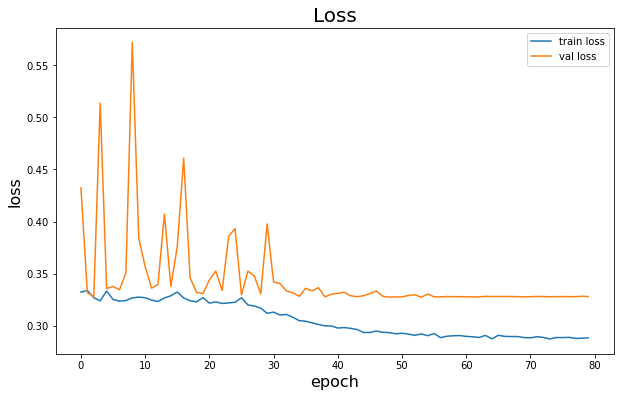

In [681]:
# loss
plt.figure(figsize=(10,6))
plt.plot(loss, label="train loss")
plt.plot(val_loss, label="val loss")
plt.title("Loss", fontsize=20)
plt.xlabel("epoch", fontsize=16)
plt.ylabel("loss", fontsize=16)
plt.legend()
plt.show()

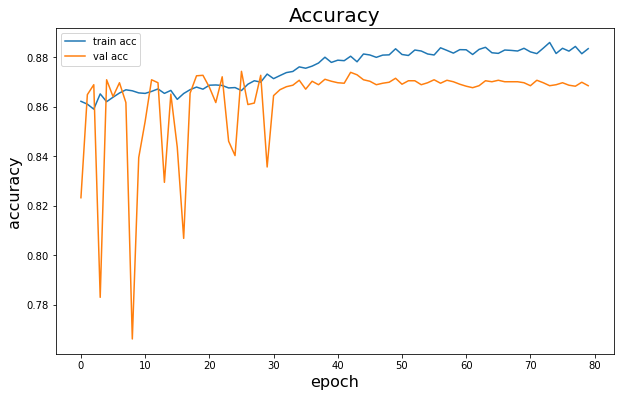

In [682]:
# accuracy
plt.figure(figsize=(10,6))
plt.plot(accuracy, label="train acc")
plt.plot(val_accuracy, label="val acc")
plt.title("Accuracy", fontsize=20)
plt.xlabel("epoch", fontsize=16)
plt.ylabel("accuracy", fontsize=16)
plt.legend()
plt.show()

# test

In [683]:
test_neg_list = os.listdir('LMDB/aclImdb_v1/aclImdb/test/neg')
test_pos_list = os.listdir('LMDB/aclImdb_v1/aclImdb/test/pos')

In [684]:
pos_path = 'C:/Users/kojun/Desktop/ML/deep learning/文字/LMDB/aclImdb_v1/aclImdb/test/pos/'
neg_path = 'C:/Users/kojun/Desktop/ML/deep learning/文字/LMDB/aclImdb_v1/aclImdb/test/neg/'

In [685]:
test_one=[]
test_pos_score = []
test_pos_content = []
for i in tqdm(range(len(test_pos_list))):
    with open(os.path.join(pos_path,test_pos_list[i]),'r',encoding="utf-8") as f:
        test_pos_score.append(int(test_pos_list[i].split('.')[0].split('_')[1]))
        test_pos_content.append(f.read())
        test_one.append('pos')

100%|█████████████████████████████████████████████████████████████████████████| 12500/12500 [00:00<00:00, 29584.29it/s]


In [686]:
test_zero=[]
test_neg_score = []
test_neg_content = []
for i in tqdm(range(len(test_neg_list))):
    with open(os.path.join(neg_path,test_neg_list[i]),'r',encoding="utf-8") as f:
        test_neg_score.append(int(test_neg_list[i].split('.')[0].split('_')[1]))
        test_neg_content.append(f.read())
        test_zero.append('neg')

100%|█████████████████████████████████████████████████████████████████████████| 12500/12500 [00:00<00:00, 26472.79it/s]


In [687]:
test_call_content = test_pos_content+test_neg_content
test_call_score = test_pos_score+test_neg_score
test_call_one_zero = test_one+test_zero

In [688]:
test = pd.DataFrame()

In [689]:
test['Contain'] = test_call_content
test['score'] = test_call_score
test['ps_ne'] = test_call_one_zero

In [690]:
test.loc[test['ps_ne']=='pos','ps_ne'] = 1
test.loc[test['ps_ne']=='neg','ps_ne'] = 0
test['ps_ne'] = test['ps_ne'].astype('float16')

In [691]:
test['Contain'] = test.apply(lambda row:text_cleaning(row['Contain']),axis=1)
test_1 = test.apply(lambda row:average_verc(row['Contain']),axis=1)

In [692]:
test_1

0        [0.0377221, -0.11066994, -0.0011112182, -0.044...
1        [0.017637972, -0.030959306, 0.048518356, -0.00...
2        [0.06898828, -0.04384847, 0.009476686, -0.0141...
3        [0.06971887, -0.044306874, 0.02073427, 0.01709...
4        [0.07801717, -0.07226931, -0.0037782707, -0.01...
                               ...                        
24995    [0.020210724, -0.10508037, 0.010371659, 0.0123...
24996    [0.058934994, -0.093938656, 0.02708537, 0.0130...
24997    [0.04310523, -0.031486597, 0.0023403151, -0.00...
24998    [0.034909923, -0.056259338, -0.009873354, 0.01...
24999    [0.08066439, -0.05083632, 0.006046505, -0.0047...
Length: 25000, dtype: object

In [693]:
g= np.empty(shape=(25000,vector_size))
for i in range(len(test)):
    g[i] = test_1[i]
g=pd.DataFrame(g)

In [694]:
y_pred = DNN_model.predict(g)
y_pred = np.argmax(y_pred,axis=1)

782/782 [==============================] - 1s 1ms/step


In [695]:
accuracy_score(test['ps_ne'],y_pred)

0.86156

In [696]:
confusion_matrix(test['ps_ne'],y_pred)

array([[10830,  1670],
       [ 1791, 10709]], dtype=int64)

In [ ]:
y_pred=dnn_modedl.predict(test_w2v_x)